In [1]:
import os
import cv2
import time
import mediapipe as mp
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import serial


In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [3]:
keypoints = [
    mp_hands.HandLandmark.WRIST, 
    mp_hands.HandLandmark.THUMB_CMC, 
    mp_hands.HandLandmark.THUMB_MCP, 
    mp_hands.HandLandmark.THUMB_IP, 
    mp_hands.HandLandmark.THUMB_TIP, 
    mp_hands.HandLandmark.INDEX_FINGER_MCP, 
    mp_hands.HandLandmark.INDEX_FINGER_PIP, 
    mp_hands.HandLandmark.INDEX_FINGER_DIP, 
    mp_hands.HandLandmark.INDEX_FINGER_TIP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_MCP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_PIP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_DIP, 
    mp_hands.HandLandmark.MIDDLE_FINGER_TIP,
    mp_hands.HandLandmark. RING_FINGER_MCP,
    mp_hands.HandLandmark.RING_FINGER_PIP,
    mp_hands.HandLandmark.RING_FINGER_DIP,
    mp_hands.HandLandmark.RING_FINGER_TIP,  
    mp_hands.HandLandmark.PINKY_MCP,
    mp_hands.HandLandmark.PINKY_PIP,
    mp_hands.HandLandmark.PINKY_DIP,
    mp_hands.HandLandmark.PINKY_TIP
    ]
    

In [4]:
if not os.path.exists('Dataset.csv'):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2,min_detection_confidence=0.5) as hands:
        list_name = ["Wrist_x", "Wrist_y", "Thumb_cmc_x", "Thumb_cmc_y", "Thumb_mcp_x", "Thumb_mcp_y", "Thumb_ip_x", "Thumb_ip_y", "Thumb_tip_x",   "Thumb_tip_y", "Index_finger_mcp_x", "Index_finger_mcp_y", "Index_finger_pip_x", "Index_finger_pip_y", "Index_finger_dip_x",  "Index_finger_dip_y", "Index_finger_tip_x", "Index_finger_tip_y", "Middle_finger_mcp_x", "Middle_finger_mcp_y", "Middle_finger_pip_x",   "Middle_finger_pip_y", "Middle_finger_dip_x", "Middle_finger_dip_y", "Middle_finger_tip_x", "Middle_finger_tip_y", "Ring_finger_mcp_x",   "Ring_finger_mcp_y", "Ring_finger_pip_x", "Ring_finger_pip_y", "Ring_finger_dip_x", "Ring_finger_dip_y", "Ring_finger_tip_x",     "Ring_finger_tip_y", "Pinky_mcp_x", "Pinky_mcp_y", "Pinky_pip_x", "Pinky_pip_y", "Pinky_dip_x", "Pinky_dip_y", "Pinky_tip_x",   "Pinky_tip_y"]
        header = ["filename", "class_name","class_no"]
        for i in range(len(list_name)):
            header.append(list_name[i])
        with open("Dataset.csv", "w") as f:
            f.write(",".join(header) + "\n")
        for class_ in os.listdir("Dataset"):
            for image in tqdm(os.listdir("Dataset/" + class_), desc="Processing", unit="image", total=len(os.listdir("Dataset/" + class_))):
                image_path = "Dataset/" + class_ + "/" + image
                image = cv2.flip(cv2.imread(image_path), 1)
                results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if not results.multi_hand_landmarks:
                    continue
                for hand_landmarks in results.multi_hand_landmarks:
                    row = [image_path, class_, os.listdir("Dataset").index(class_)]
                    for i in range(len(keypoints)):
                        row.append(hand_landmarks.landmark[keypoints[i]].x)
                        row.append(hand_landmarks.landmark[keypoints[i]].y)
                    with open("Dataset.csv", "a") as f:
                        f.write(",".join([str(i) for i in row]) + "\n")



In [5]:
csvs_out_train_path = 'Dataset.csv'

In [6]:
def get_coords(csv_path):
  
  df = pd.read_csv(csv_path)
  df1= df.copy()
  df1.drop(columns=['filename'], inplace=True)
  classes = df1.pop('class_name').unique()
  y = df1.pop('class_no')
  x = df1.astype('float64')
  y = keras.utils.to_categorical(y)

  return x, y, classes, df


In [7]:
x, y, classes, df = get_coords(csvs_out_train_path)

x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                  test_size=0.15)

In [8]:
def embed_coords(scores):
  
  reshaped_inputs = keras.layers.Reshape((21, 2))(scores)
  points = reshaped_inputs
  embedding = keras.layers.Flatten()(points)
  
  return embedding

In [9]:
inputs = tf.keras.Input(shape=(42))
embedding = embed_coords(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(classes), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 reshape (Reshape)           (None, 21, 2)             0         
                                                                 
 flatten (Flatten)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 128)               5504      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0     

Epoch 1/200
2069/2069 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.7576
Epoch 1: val_accuracy improved from -inf to 0.90873, saving model to weights.best.hdf5
2069/2069 [==============================] - 16s 6ms/step - loss: 0.5886 - accuracy: 0.7576 - val_loss: 0.1808 - val_accuracy: 0.9087
Epoch 2/200
2062/2069 [============================>.] - ETA: 0s - loss: 0.2190 - accuracy: 0.9032
Epoch 2: val_accuracy improved from 0.90873 to 0.96952, saving model to weights.best.hdf5
2069/2069 [==============================] - 11s 5ms/step - loss: 0.2190 - accuracy: 0.9034 - val_loss: 0.0929 - val_accuracy: 0.9695
Epoch 3/200
2058/2069 [============================>.] - ETA: 0s - loss: 0.1447 - accuracy: 0.9469
Epoch 3: val_accuracy improved from 0.96952 to 0.99075, saving model to weights.best.hdf5
2069/2069 [==============================] - 11s 5ms/step - loss: 0.1443 - accuracy: 0.9471 - val_loss: 0.0400 - val_accuracy: 0.9908
Epoch 4/200
2066/2069 [===========

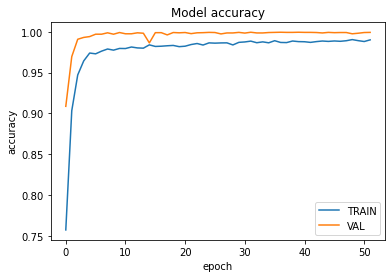

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)


history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint, earlystopping])

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

183/183 [==============================] - 1s 3ms/step
(5840, 42) (5840, 6) <class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

      Class0       0.99      1.00      1.00       771
      Class1       1.00      1.00      1.00      1025
      Class2       1.00      1.00      1.00       985
      Class3       1.00      1.00      1.00      1508
      Class4       1.00      1.00      1.00       712
      Class5       1.00      1.00      1.00       839

    accuracy                           1.00      5840
   macro avg       1.00      1.00      1.00      5840
weighted avg       1.00      1.00      1.00      5840



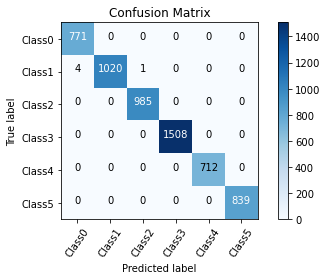

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

y_pred = model.predict(x_val)
print(x_val.shape, y_pred.shape, type(y_pred), type(x_val))

y_pred_label = [classes[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [classes[i] for i in np.argmax(y_val, axis=1)]

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      classes,
                      title ='Confusion Matrix')

print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [12]:
x_val.shape

(5840, 42)

In [13]:
def findSpeed(image):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2,min_detection_confidence=0.5) as hands:
        results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if not results.multi_hand_landmarks:
            return
        coordinates = np.array([[res.x, res.y] for res in results.multi_hand_landmarks[0].landmark]).flatten()
        X = coordinates.reshape(1, 42)
        y = model.predict(X)
        y_pred = [classes[i] for i in np.argmax(y, axis=1)]
        return y_pred[0]

In [ ]:
camera_video = cv2.VideoCapture(0)
camera_video.set(3, 1280)
camera_video.set(4, 720)
cv2.namedWindow('Hand Gesture Recognition', cv2.WINDOW_NORMAL)

arduino = serial.Serial(port='COM4', baudrate=115200, timeout=.1)
time.sleep(2)

while 1:
            suc, img = cap.read()
            img = self.find_hands(img)
            pts = self.find_posi(img)  # points of the hand
            fan_input = self.count_open(pts)
            prev_fan_input = fan_input
            time.sleep(1)
            print("fi- {}".format(fan_input))

            if fan_input == '1':
                arduino.write(b'1')

            elif fan_input == '2':
                arduino.write(b'2')

            elif fan_input == '3':
                arduino.write(b'3')

            elif fan_input == '4':
                arduino.write(b'4')

            elif fan_input == '5':
                arduino.write(b'5')

            elif fan_input == '0':
                arduino.write(b'0')

            cv2.imshow("image", img)

            if cv2.waitKey(1) & 0xFF == ord("q"):
                break


# while camera_video.isOpened():
#     ok, frame = camera_video.read()
#     time1 = time.time()
#     if not ok:
#         continue

frame_height, frame_width, _ = frame.shape
   
fingers = findSpeed(frame)
print(fingers)
frame = cv2.flip(frame, 1)
time2 = time.time()
fps = 0
if (time2 - time1) > 0:
    fps = 1.0 / (time2 - time1)
cv2.putText(frame, 'FPS: {}'.format(int(fps)), (500, 150),
                cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 3)
cv2.putText(frame, 'CLASS: {}'.format(fingers), (10, 150),
                 cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 3)
time1 = time2
    
cv2.imshow('Hand Gesturen Recognition', frame)
k = cv2.waitKey(1) & 0xFF
# if(k == 27):
    # break
camera_video.release()
cv2.destroyAllWindows()